In [1]:
from os import path

import random
import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

import matplotlib.pyplot as plt

import dataloaders
import networks.utils as utils
import networks.wdcgan_gp as wdcgan

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda' #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREATS = torch.get_num_threads()
    print("Number of Threats: ", NUM_THREATS)
else:
    NUM_THREATS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threats:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data","tmdb-64")
TABLE_PATH = path.join("data","tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3 # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
D_NORM_LAYER_TYPE = "instance" # "none", "instance", "layer"
PADDING_MODE = "reflect"
COLORMODE="RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
BETA1 = 0. #formerly 0.5
BETA2 = 0.9 #formerly 0.999
N_CRITIC = 5
LAMBDA_GP = 10

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs","wdcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 10
SAVE_FAKES_EVERY_N_EPOCHS = 5

### Load dataset

In [5]:
# Poster subset:
GENRE=['Horror']
GENRE_LOGIC='and'
OG_LANG=None
YEAR=None
RUNTIME=(40, np.inf)
MAX_NUM=None
SORT='popularity'

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                    img_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                    colormode=COLORMODE,
                                    img_in_ram=False,
                                    genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR, runtime=RUNTIME,
                                    max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_THREATS, pin_memory=True)

Sample dataset:

The dataset has 18119 entries.


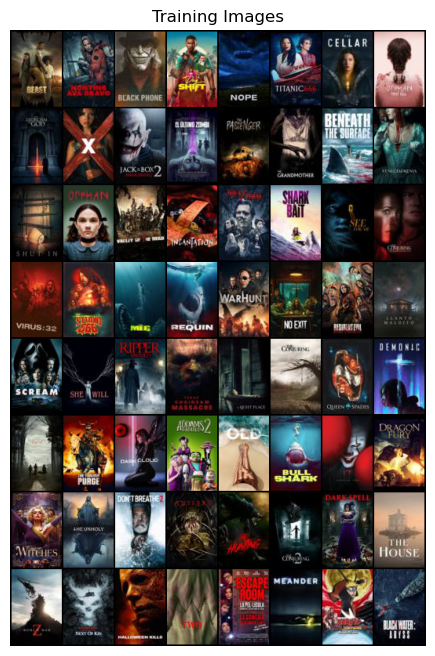

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [7]:
generator, discriminator = wdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G, base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, d_norm_layer_type=D_NORM_LAYER_TYPE, padding_mode=PADDING_MODE, device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, 1, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, 96, 64))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14        

In [8]:
trainer = wdcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO, d_params=discriminator.parameters(), g_params=generator.parameters(), learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, n_critic=N_CRITIC, lambda_gp=LAMBDA_GP, device=device)

## Train

[0/19]	Loss_D: -4.7288	Loss_G: 2.0333	D(x): 4.8274	D(G(z)): -0.7180 / -2.0333: 100%|██████████| 284/284 [00:45<00:00,  6.25it/s]


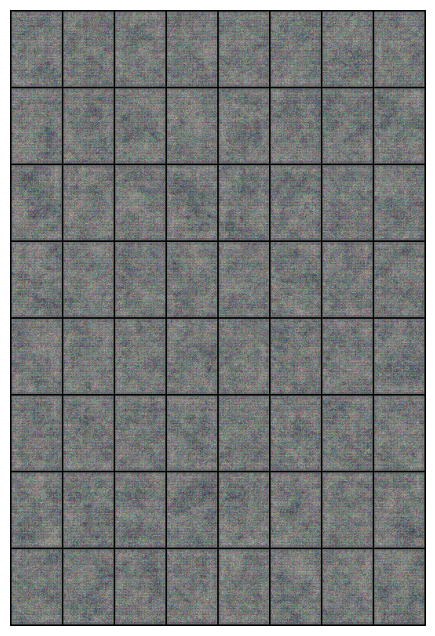

[1/19]	Loss_D: -7.9284	Loss_G: 3.6010	D(x): 3.3460	D(G(z)): -4.9909 / -3.6010: 100%|██████████| 284/284 [00:44<00:00,  6.37it/s] 
[2/19]	Loss_D: -8.5097	Loss_G: 10.1824	D(x): 2.0169	D(G(z)): -7.6010 / -10.1824: 100%|██████████| 284/284 [00:44<00:00,  6.35it/s] 
[3/19]	Loss_D: -9.0166	Loss_G: 5.7710	D(x): 1.3798	D(G(z)): -8.1731 / -5.7710: 100%|██████████| 284/284 [00:44<00:00,  6.35it/s]    
[4/19]	Loss_D: -10.6241	Loss_G: 12.1224	D(x): 3.1411	D(G(z)): -7.9796 / -12.1224: 100%|██████████| 284/284 [00:44<00:00,  6.38it/s]  
[5/19]	Loss_D: -9.9612	Loss_G: 7.6256	D(x): 1.5982	D(G(z)): -10.9714 / -7.6256: 100%|██████████| 284/284 [00:44<00:00,  6.42it/s]    


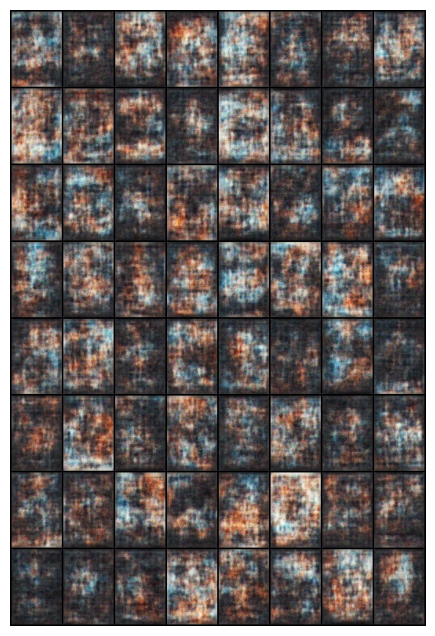

[6/19]	Loss_D: -12.0056	Loss_G: 14.9529	D(x): 0.4809	D(G(z)): -12.6154 / -14.9529: 100%|██████████| 284/284 [00:44<00:00,  6.39it/s] 
[7/19]	Loss_D: -12.4481	Loss_G: 16.5605	D(x): 1.2867	D(G(z)): -13.2712 / -16.5605: 100%|██████████| 284/284 [00:44<00:00,  6.45it/s] 
[8/19]	Loss_D: -11.1690	Loss_G: 14.5961	D(x): 0.4348	D(G(z)): -13.6842 / -14.5961: 100%|██████████| 284/284 [00:44<00:00,  6.42it/s] 
[9/19]	Loss_D: -14.7229	Loss_G: 18.2561	D(x): -1.0788	D(G(z)): -17.2914 / -18.2561: 100%|██████████| 284/284 [00:44<00:00,  6.45it/s]
[10/19]	Loss_D: -12.6823	Loss_G: 18.2366	D(x): 1.2559	D(G(z)): -16.7376 / -18.2366: 100%|██████████| 284/284 [00:45<00:00,  6.30it/s] 


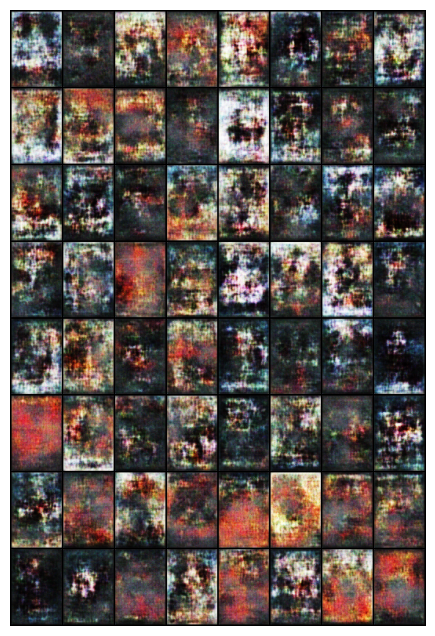

[11/19]	Loss_D: -10.6922	Loss_G: 18.7007	D(x): -0.3826	D(G(z)): -15.7454 / -18.7007: 100%|██████████| 284/284 [00:44<00:00,  6.38it/s]
[12/19]	Loss_D: -17.9755	Loss_G: 18.7540	D(x): -0.5804	D(G(z)): -19.7682 / -18.7540: 100%|██████████| 284/284 [00:44<00:00,  6.41it/s]
[13/19]	Loss_D: -15.1875	Loss_G: 20.4956	D(x): 1.6281	D(G(z)): -18.7326 / -20.4956: 100%|██████████| 284/284 [00:44<00:00,  6.41it/s] 
[14/19]	Loss_D: -14.9666	Loss_G: 22.4877	D(x): -0.1329	D(G(z)): -16.7591 / -22.4877: 100%|██████████| 284/284 [00:44<00:00,  6.38it/s]
[15/19]	Loss_D: -17.8892	Loss_G: 25.6329	D(x): -2.7858	D(G(z)): -23.0912 / -25.6329: 100%|██████████| 284/284 [00:44<00:00,  6.39it/s] 


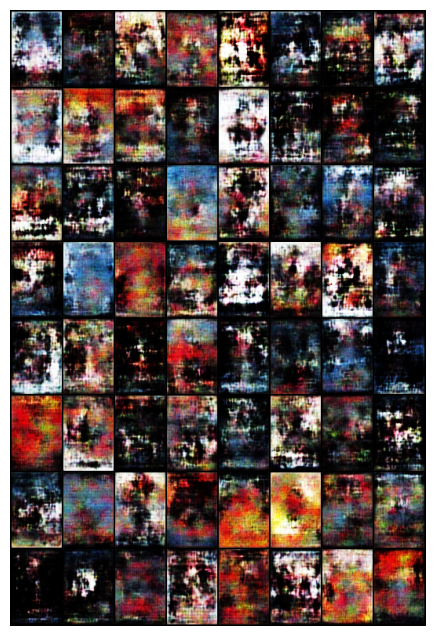

[16/19]	Loss_D: -16.7067	Loss_G: 23.6407	D(x): -5.5817	D(G(z)): -26.9468 / -23.6407: 100%|██████████| 284/284 [00:44<00:00,  6.39it/s] 
[17/19]	Loss_D: -16.8610	Loss_G: 25.7196	D(x): -4.2459	D(G(z)): -25.2274 / -25.7196: 100%|██████████| 284/284 [00:44<00:00,  6.40it/s] 
[18/19]	Loss_D: -18.0781	Loss_G: 28.0591	D(x): -7.8083	D(G(z)): -28.2727 / -28.0591: 100%|██████████| 284/284 [00:44<00:00,  6.42it/s] 
[19/19]	Loss_D: -16.3644	Loss_G: 28.1845	D(x): -4.6046	D(G(z)): -23.4361 / -28.1845: 100%|██████████| 284/284 [00:44<00:00,  6.43it/s] 


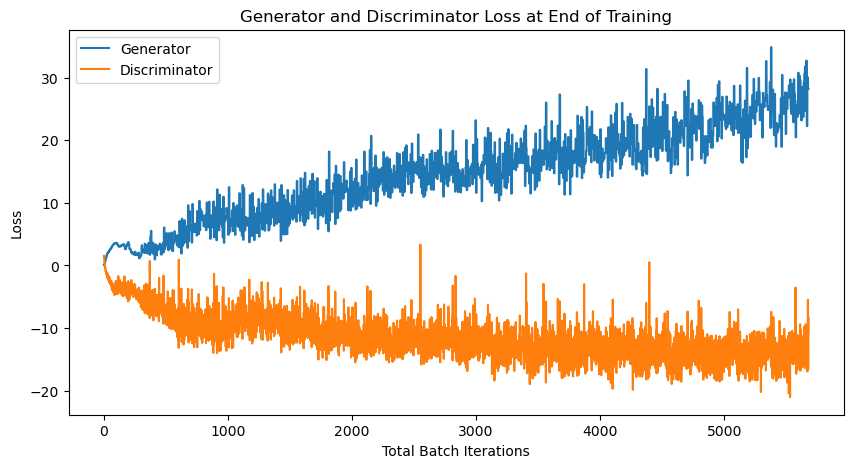

In [9]:
SHOW_GRAPHS = True

trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device, fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS, show_graphs=SHOW_GRAPHS)

### Show results

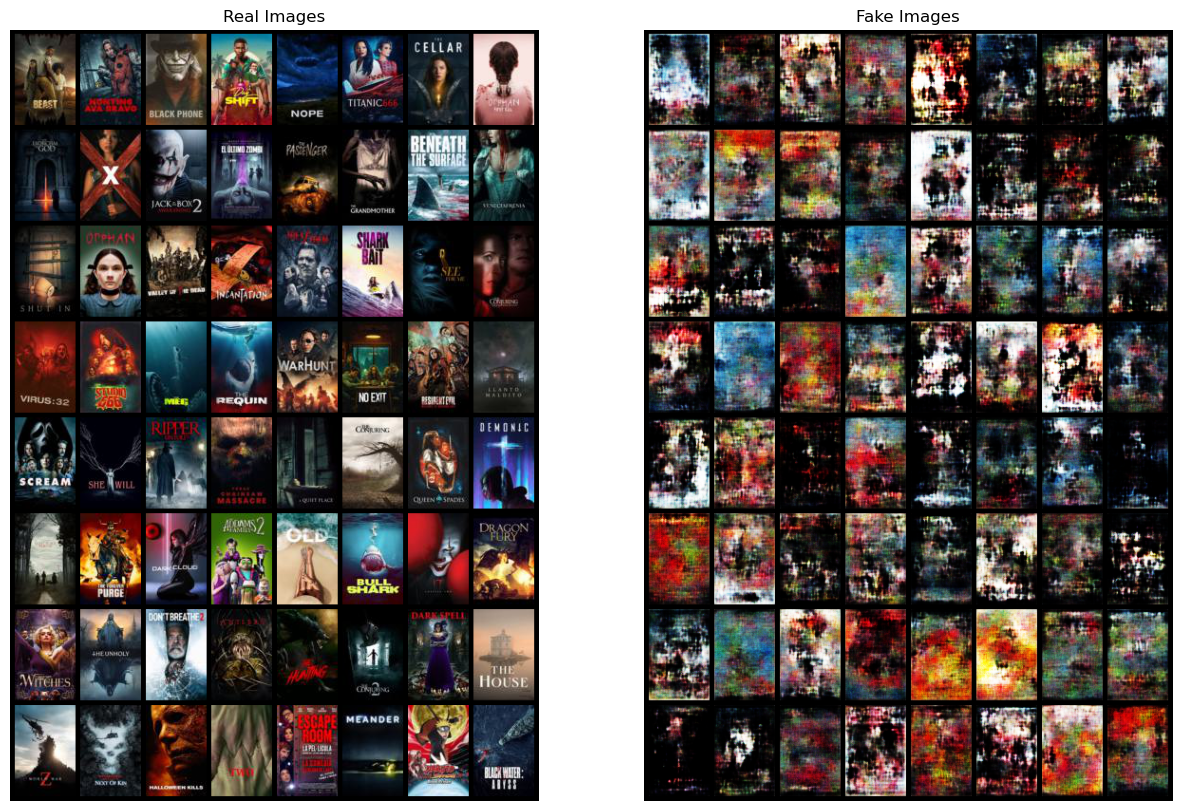

In [10]:
with torch.no_grad():
    sample_fakes = generator(trainer.noise_samples).detach().cpu()
sample_fakes = vutils.make_grid(sample_fakes, padding=5, normalize=True)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_reals[0].to(device)[:NUM_SAMPLES], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(sample_fakes, (1, 2, 0)))
plt.show()

fig.savefig(path.join(trainer.last_out_dir, "real_vs_fake.png"))